In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.2/512.2 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.13.1 / PyTorch 2.5.1+cu121


In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

Above cell

We define the number of clients to use and the batch size(the amount of data processed in one forward and backward pass).

We then load the CIFAR-10 data set in and split it in to 10 parts one part for each client. We then assign partitions for clients
We then split that partition to 80-20 test split. Then for the given partition we normalise(set the mean and std dev to 0.5) the image data and turn it in to a PyTorch tensor.  

We then apply these transforms in apply transform. In line 22 we apply apply the transoforms using Torchvisions built in .with_transform we dont need to specify the batch because it taken care by with_transform.

trainloader is our data for training in a batched form and is shuffled.
vallloader is our test data again batched but not shuffled.
testloader is loading the whole dataset for evaluation and applys transformations


Below cell

This code is visualizing the cifar-10 dataset.
We load the first clients data then get the image and label for it
Rearrange from pytorch tensor to matlab usable format in line 7

Then images are renormalized since it was normalized in loaddatasets in line 10

The rest is matlib code. Creates the plot plots them and displays

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

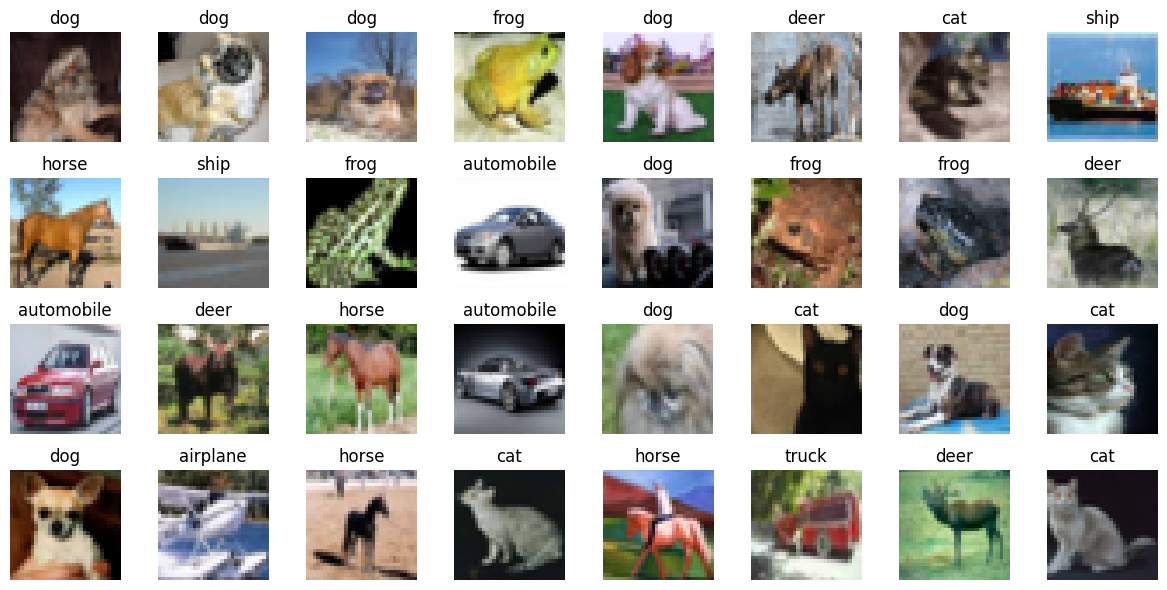

In [ ]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()

# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        #Simple CNN

We initialize the cnn as it works great with images

We initialize the parent class of Net which is nn.Module.  
Then we start registering our layers. First layer in a CNN is often a convolutional layer. This layer usually has 3 inputs since there are 3 rgb channels for images. This layer applies a filter to find the edges, textures or objects in the image. We also define the output as 6 feature maps. And finally we apply a 5x5 filter to do the filtering.

We then have a pooling layer which is a maximum pooling layer. This layer essentially takes the max value from a 2x2 region meaning, keeps the important features and discards the rest while retaining feature map count.

We then have another conv layer does the same thing but now there are 16 feature maps. Helps extract more complex features from the pooling layer.

We then have our first fully connected layer. Our input is the flattened features from the convolutional layers. 16 feature maps then 5x5 for the size of the features. We then output 120 neurons

Second FC layer. takes 120 inputs gives 84 outputs. Processes higher level features and "compresses" the model making it more dense.

Final layer takes those 84 features as input and produces 10 outputs which are the labels from the CIFAR-10 dataset.


We then have the forward pass defined. x is passed in which is the image data.
We then apply the mentioned layers so conv layer then relu actv func is applied. Then we apply the pool layer. This reduces the computational load making the model more efficent.  

The same process is than repeated with the conv2 layer.
We than flatten to a 1D vector to prepare for the fully connected layer.

Then we pass the image data thru the first fully connected layer andthen use ReLu activation. Repeat for the next step just making it more denser
We than have the last layer where we get the 10 labels.


In [1]:

def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

The train function defines the optimizer and the loss function to be used in the training program

Then we put the model in to training mode in line 6

Then we run the epochs for the specified amount.
We load the batches and move them to the specified device in this case gpu

We zero the gradient to avoid accumulation.

We perform a forward pass line 12 gathers the predicted outputs,then next line we calculate the loss giving it the predicted and the true labels.

Then we do a backward pass and run the optimizer which is adam in this case.

We gather out loss for accuracy calculation then for verbose we have the verbose print statement.

for he test function we are using the same loss func. then we set the model in eval mode.

disable gradient tracking to save memory and speed up computation

we itirate over the batches in tetloader. then we do a foward pass and compute the loss.



BELOW CELL

we load the data then crate a CNN instance.

we than have the training loop for 5 epochs
we evaluate the model using test defined above

and we do final test to evalute the model once the epochs are over.


In [ ]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.05906869757175445, accuracy 0.318
Epoch 2: validation loss 0.05476619291305542, accuracy 0.376
Epoch 3: validation loss 0.05278158915042877, accuracy 0.397
Epoch 4: validation loss 0.049134974598884586, accuracy 0.448
Epoch 5: validation loss 0.04983708333969116, accuracy 0.435
Final test set performance:
	loss 0.050338666260242464
	accuracy 0.4106


Set and get paramters used by the FL algo to get weights and biases.

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

We implement the client here extending the flwr.client.NumPyClient

we init the client with local instances of the neural network,
the train data and validation data set are also loaded. In a real environment client would load its own dataset and its own model instance.

get parameters send the clients current model parameters to the server. This funtion is used by the server to get the model paramters for aggregation.

the fit function received the global params and trains the model locally on client dataset.

the evaluate function evaluates the model using the validation dataset and sends the results to the server

In [ ]:
class FlowerClient(NumPyClient):#Define client using numpyclient

#This class implements 3 methods.

    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
#Return local parameters
    def get_parameters(self, config):
        return get_parameters(self.net)
#get parameters from server, train locally, return updated model (called by server)
    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}
#evaludating model on local data.
    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

This is the function to crate the client.
We specify device type cpu or gpu
load the data
then return the client instance
client app is used to managed the clients

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

#For creating clients.

We define the strat that we are going to be using here

In [ ]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

we define our server on the code above. Set the number of rounds we want to do.
then we just use serverappcomponents to initilize the server

BELOW CELL
we give the resources we have depending on device type

In [ ]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

Here we run the simulation using the defined server and client app, number of clients and our config.

In [ ]:
# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2397) 2024-12-08 22:39:22.233138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2397) 2024-12-08 22:39:22.267746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2397) 2024-12-08 22:39:22.277401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=2397) 2024-12-08 22:39:23.935737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning:

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

same process as before just this time we add the weigted avarage function to see our accuracy.

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    )

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create a new server instance with the updated FedAvg strategy
server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=7404) 2024-12-08 22:55:27.550553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=7404) 2024-12-08 22:55:27.570457: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=7404) 2024-12-08 22:55:27.576599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=7404) 2024-12-08 22:55:28.689192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=74